In [3]:
import functions
import networkx as nx
import numpy as np
import osmnx as ox

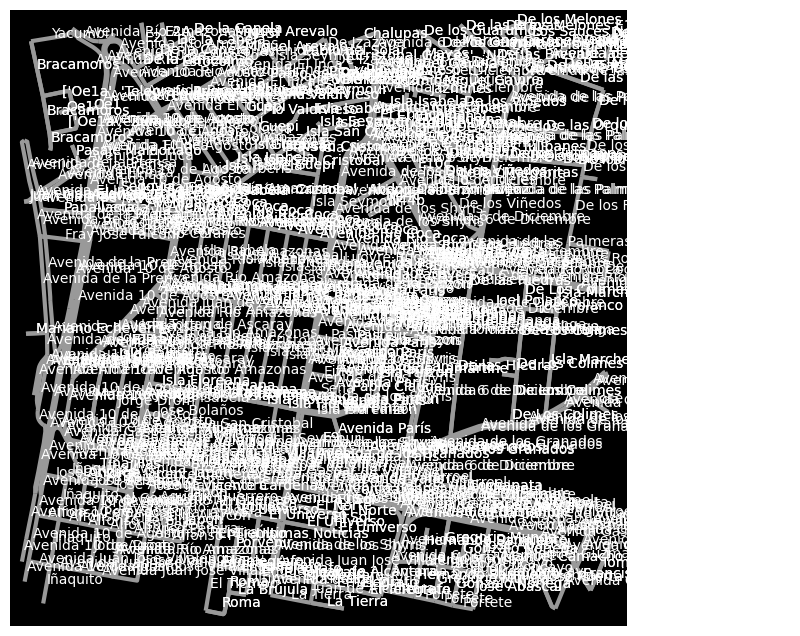

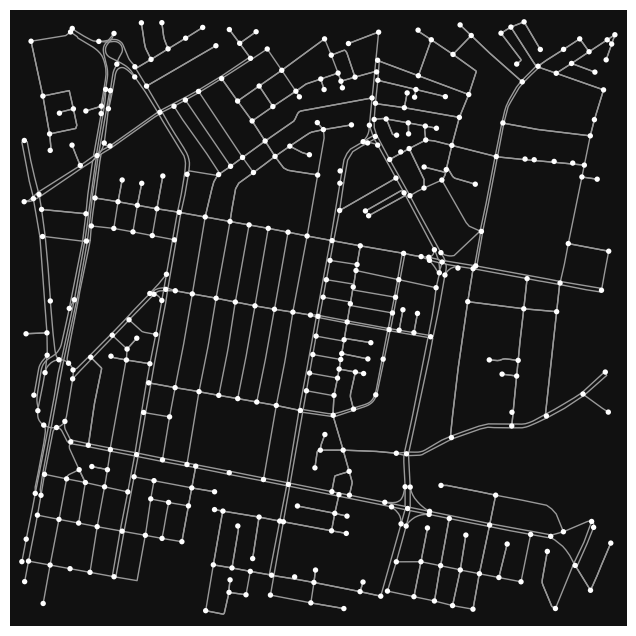

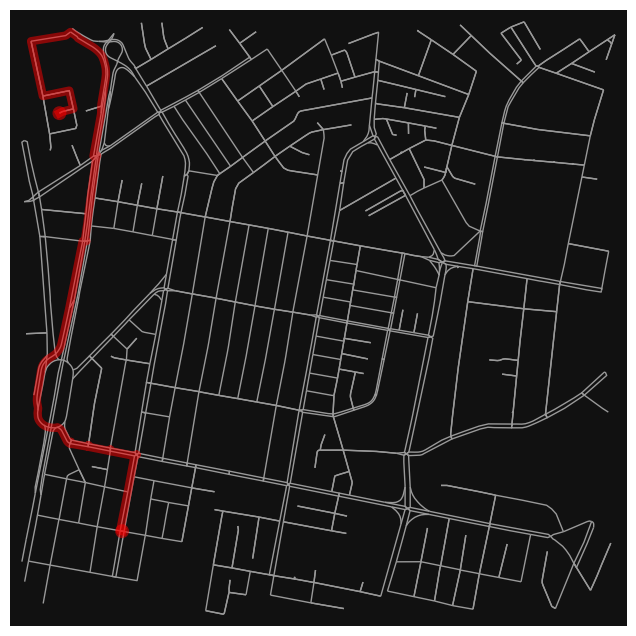

In [4]:
# Get the map 
#G3 = functions.get_node(-0.16916, -78.47632, 400) #pos 1 
#G3 = functions.get_node(-0.16279, -78.47848, 400) # pos2
G3 = functions.get_node(-0.16509, -78.47888 , 1000) # pos 3 
# plot the netwrok
#nx.draw(G3, with_labels=True)

# This location is 4km round the carlina park: 
G = ox.project_graph(ox.graph_from_point((-0.16509, -78.47888 ), dist=1000, network_type='drive'))
G3 = ox.consolidate_intersections(G, tolerance=10, rebuild_graph=True, dead_ends=True)

# Plotting the map: 
ox.plot_graph(G3)

# Ploting just the nodes  
#route0_G3 = nx.shortest_path(G3, 12, 12)
#route1_G3 = nx.shortest_path(G3, 50, 50)
#routes_G3 = [route0_G3 , route1_G3]#,route2_G3,route3_G3,route4_G3,route5_G3,route6_G3]

#fig, ax = ox.plot_graph_routes(G3, routes_G3, route_linewidth=6, node_size=0)

# plot route from pos 1 tests 
#route00_G3 = nx.shortest_path(G3, 25, 54) # 12-25 ya salio , 25-54 ya salio , 12-45 ya salio , 12-54 ya salio 

# routes for pos 2 tests 
#route00_G3 = nx.shortest_path(G3, 18, 54) # 12-54 ya salio  , # todos los de arriba salieron 

# plot route from pos 3 tests 
route00_G3 = nx.shortest_path(G3, 18, 54) # 18-36 ya  salio  18-54 ya salio ,  67-54 si sale , 12-45 si sale

#Plot routes  
fig, ax = ox.plot_graph_route(G3, route00_G3, route_linewidth=6, node_size=0)

In [7]:
# def simulation function 

# get list of nodes 
list_nodes = list(G3.nodes)

# weights 
w_d = 0.6
w_a = 0.4

# get dictionary with geocordinates of each of the nodes 

coordiantes = functions.get_geo_coordinates( G3 )

# defining initial and final node
initial_node = list_nodes[2]
final_node = list_nodes[391]

# loop to finde the path: 

node_i = initial_node 

# to store the routes:
route= {}

path = []

# bug list
bug_list = []

# no exit list 
no_exit_list = []


while node_i != final_node:

    # store all nodes the agent pass through: 
    path.append(node_i)
    
    # measure the angle and distnac between the node_i and the destination node
    angle_i = functions.get_angle( coordiantes[ node_i ], coordiantes[ final_node] )
    dist_i = functions.get_distance( coordiantes[ node_i ], coordiantes[ final_node] ) 

    # get the neighbours of the node. The neighbours are directed nodes
    neighbors = list(G3.neighbors(node_i))

    # get probality of pick a given neighbour
    factors = {}

    for node in neighbors :
        # measure angle and dist of neighbors towards final node 
        angle_neighbor = functions.get_angle( coordiantes[ node ], coordiantes[ final_node] )
        dist_neighbor = functions.get_distance( coordiantes[ node ], coordiantes[ final_node] )

        # calculate the probability of picking a node 
        factors[node] = functions.get_factor(dist_neighbor , angle_neighbor , dist_i , angle_i , w_d , w_a )

    # get probabilities
    proba_dic = functions.get_probability(factors)


    print("estoy en el nodo  ", node_i, " mis opciones son : ", proba_dic)

    # list of probable nodes_id: 
    list_proba = list(proba_dic.keys())

    # countador de cuantas veces paso por un nodo 
    repeticions = path.count(node_i)

    for node in list_proba:
        counter = path.count(node)
        if node in path:
            proba_dic[node] = proba_dic[node]*0.4
            if counter > 2:
                 proba_dic[node] = proba_dic[node]*(0.4**counter)


    # if i have pas more than two times by a node 
    if repeticions > 2:
        
        # sotre node_i in wich bug is produced 
        bug_node = node_i
        bug_list.append(node_i)
        print("bugg en el nodo : " , bug_node )

        # count how many times a bug node has been pass through.
        counter = bug_list.count(node_i)

        if counter >= 3:
            vecinos_i = list(G3.neighbors(node_i))
            for vecino in vecinos_i:
                if vecino in  bug_list:
                    route[bug_node][vecino] = 0.0
                    proba_dic[vecino] = route[bug_node][vecino]
                    print("me quedo en el nodo: " , node_i, "acualice probabiliades: ", proba_dic)
                    #print(route)
            #break
        
    # check for node with no exit i.e no neigbors 
    if len(neighbors) == 0:
        # store in route 
        print("estoy en el nodo " , node_i , "no hay salida")
        no_exit_node = node_i
        route[no_exit_node] = {}
        no_exit_list.append(no_exit_node)

        # acutalizo la posicion al nodo anterior
        node_i= path[-2]

        # check neihbours
        vecino_j = list(G3.neighbors(node_i))

        # acualizo la proabilidad de volver al nodo sin salida a 0
        for vecino in vecino_j:
            if vecino in no_exit_list:
                route[node_i][no_exit_node] = 0.0
                proba_dic = route[node_i]
                print("volvi al nodo: ", node_i, "se acutliazo las lista de probilidades a : " ,proba_dic)
        #break
                
    # check if the node has no posible routes to the destination
    no_options = all( options == 0 for options in proba_dic.values())       
    if no_options:
        position = path.index(node_i)
        no_options_node = node_i
        no_exit_list.append(node_i)
        print("ninguno de los caminos posibles es correcto")
        print("regreso al nodo", path[position - 1 ])
        node_i =  path[position - 1 ]
        route[node_i][no_options_node] = 0.0
        proba_dic = route[node_i]
        
        # checkear que no vuelva a una ruta sin salida: 
        vecino_z = vecino_j = list(G3.neighbors(node_i))
        for vecino in vecino_z:
            if vecino in no_exit_list:
                position_i = path.index(node_i)
                node_j = path[position_i -1]
                print("debo regresar al node " , node_j, " no debo ir a ", node_i)
                route[node_j][node_i] = 0.0
                proba_dic = route[node_j]
                print(proba_dic)
        #break

    # stop simulation if bug 
    if repeticions > 15:
        print(" ERROR: el nodo " , node_i ," se repite mas de 15 veces")
        break

    # add to route:
    route[node_i] = proba_dic
    
    # ge the node id with max probability
    node_id = max(proba_dic , key= proba_dic.get)

    # get the max probability    
    Proba = proba_dic[node_id]
        
    print("estoy en el nodo: " , node_id)

    # update position
    node_i = node_id

estoy en el nodo   2  mis opciones son :  {272: 0.20518536281616157, 175: 0.27963165660059563, 0: 0.22004251024386776, 172: 0.295140470339375}
estoy en el nodo:  172
estoy en el nodo   172  mis opciones son :  {165: 0.5890097699781311, 2: 0.41099023002186896}
estoy en el nodo:  165
estoy en el nodo   165  mis opciones son :  {172: 0.18952175890970432, 173: 0.3016299528097848, 170: 0.25029192471693806, 153: 0.25855636356357287}
estoy en el nodo:  173
estoy en el nodo   173  mis opciones son :  {165: 0.3020733561968366, 174: 0.3663407459610367, 409: 0.3315858978421268}
estoy en el nodo:  174
estoy en el nodo   174  mis opciones son :  {173: 1.0}
estoy en el nodo:  173
estoy en el nodo   173  mis opciones son :  {165: 0.3020733561968366, 174: 0.3663407459610367, 409: 0.3315858978421268}
estoy en el nodo:  409
estoy en el nodo   409  mis opciones son :  {173: 1.0}
estoy en el nodo:  173
estoy en el nodo   173  mis opciones son :  {165: 0.3020733561968366, 174: 0.3663407459610367, 409: 0.33

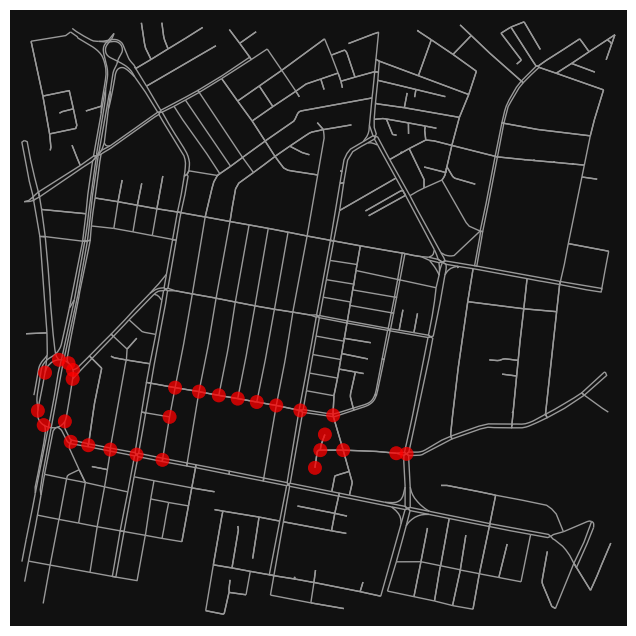

In [8]:
route
routes_g = []
for n in list(route.keys()):
    if len(route[n]) > 0:
        route_G = nx.shortest_path(G3, n, n)
        routes_g.append(route_G)

fig, ax = ox.plot_graph_routes(G3, routes_g, route_linewidth=6, node_size=0)